# 5C. ADI forward modeling of planets in disks (with JWST data)

> Author: *Valentin Christiaens*  
> Last update: *20/01/2023*  
> Suitable for VIP *v1.6.0* onwards.

**Table of contents**

* [5.7. Roll subtraction](#5.7.-Roll-subtraction)
    - [5.7.1. Images](#5.7.1.-Images)
    - [5.7.2. Optimal disk parameters through NEGFD](#5.7.2.-Optimal-disk-parameters-through-NEGFD)
    - [5.7.3. Optimal planet parameters through NEGFC](#5.7.3.-Optimal-planet-parameters-through-NEGFC)
    
* [5.8. Iterative PCA](#5.8.-Iterative-PCA)
    - [5.8.1. Images](#5.8.1.-Images)
    - [5.8.2. Optimal disk parameters through NEGFD](#5.8.2.-Optimal-disk-parameters-through-NEGFD)
    - [5.8.3. Optimal planet parameters through NEGFC](#5.8.3.-Optimal-planet-parameters-through-NEGFC)

This tutorial shows:

- how to find the optimal radiative transfer model of a disk, within a grid of models;
- how to find the optimal parameters for an embedded (proto)planet;

either using roll subtraction or iterative PCA, using as an example JWST/NIRCam data on PDS 70 (published in Christiaens et al. 2024).

-----------

Let's first import a couple of external packages needed in this tutorial:

In [154]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

In [184]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.6.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.6.0 or above to run this notebook."
    raise ValueError(msg)
else:
    from vip_hci.fits import open_fits, write_fits
    from vip_hci.fm import firstguess_fd, interpolate_model
    from vip_hci.greedy import ipca
    from vip_hci.psfsub import roll_sub
    from vip_hci.var import frame_center

VIP version:  1.6.0


## Loading the JWST data used in this tutorial

To showcase how to perform roll subtraction and iterative PCA, let's use JWST/NIRCam observations of protoplanetary disk PDS 70 acquired in the F187N and F480M filters (details on the data in Christiaens et al. 2024). These are non-coronagraphic, non-saturated observations obtained with a small window of the NIRCam detector - allowing faster readout, hence shorter integrations avoiding saturation of the star.

In [156]:
cubename_short = '../datasets/nircam_PDS70_cube_F187N.fits'
angname_short = '../datasets/nircam_PDS70_pa_F187N.fits'
cubename_long = '../datasets/nircam_PDS70_cube_F480M.fits'
angname_long = '../datasets/nircam_PDS70_pa_F480M.fits'
modelname_long = '../datasets/nircam_PDS70_F480M_disk_models_alpha1e-1-1e-2_amin0.001-0.01.fits'
binary_mask_long = '../datasets/nircam_PDS70_F480M_optim_mask.fits'

cube_short, head_short = open_fits(cubename_short, header=True)
pa_short = open_fits(angname_short)
cube_long, head_long = open_fits(cubename_long, header=True)
pa_long = open_fits(angname_long)

FITS HDU-0 data and header successfully loaded. Data shape: (10, 31, 31)
FITS HDU-0 data successfully loaded. Data shape: (10,)
FITS HDU-0 data and header successfully loaded. Data shape: (10, 51, 51)
FITS HDU-0 data successfully loaded. Data shape: (10,)


These data were first calibrated using the JWST pipeline, and further preprocessed with VIP routines for bad pixel correction and star centering (see examples in **Tutorial 2**), such that the resulting data `cube` for each filter only contains 10 images, 5 for each of the two roll angles. The `pa` 1D arrays contain these roll angles, which are two sets of values separated by 5º, to be used to align the images north up and east left. The star was shifted at different locations of the detector sub-array for the 5 images obtained at each roll angle, such that the images in `cube` are cropped to only capture the common field of view probed by this 5-point dither pattern. Given the different pixel scales, this leads to different final sizes for F187N and F480M.

Let's now load the pixel scale for each dataset, based on header information:

In [157]:
px_area_short = head_short['PIXAR_A2']
plsc_short = np.sqrt(px_area_short)

px_area_long = head_long['PIXAR_A2']
plsc_long = np.sqrt(px_area_long)

msg = "The pixel scales for the F187N and F480M images are {:.2f} and {:.2f} mas/px, respectively"
print(msg.format(plsc_short*1000, plsc_long*1000))

The pixel scales for the F187N and F480M images are 30.75 and 63.01 mas/px, respectively


Let's define the pivot wavelength for each filter: 

In [158]:
lbda_short = 1.87e-6 # pivot wavelength of the F187N filter
lbda_long = 4.8e-6   # pivot wavelength of the F480M filter

The presence of a bright inner disk may inflate the core of the PSF. Therefore let's rather consider the theoretical FWHM instead of fitting a 2D Gaussian to the PDS 70 images. 

In [159]:
D = 4.5 # diameter of JWST in meters
arcsec_in_rad = 206265 # conversion factor from arcsec to radians

fwhm_short = 1.22*lbda_short*arcsec_in_rad/(D*plsc_short)
fwhm_long = 1.22*lbda_long*arcsec_in_rad/(D*plsc_long)

msg = "The FWHM of the PSF in the F187N and F480M images are {:.2f} and {:.2f} px, respectively"
print(msg.format(fwhm_short, fwhm_long))

The FWHM of the PSF in the F187N and F480M images are 3.40 and 4.26 px, respectively


### Visualizing the JWST image cube:

Checking a couple of frames in the F187N and F480M cubes of images shows the high stability of the NIRCam PSF:

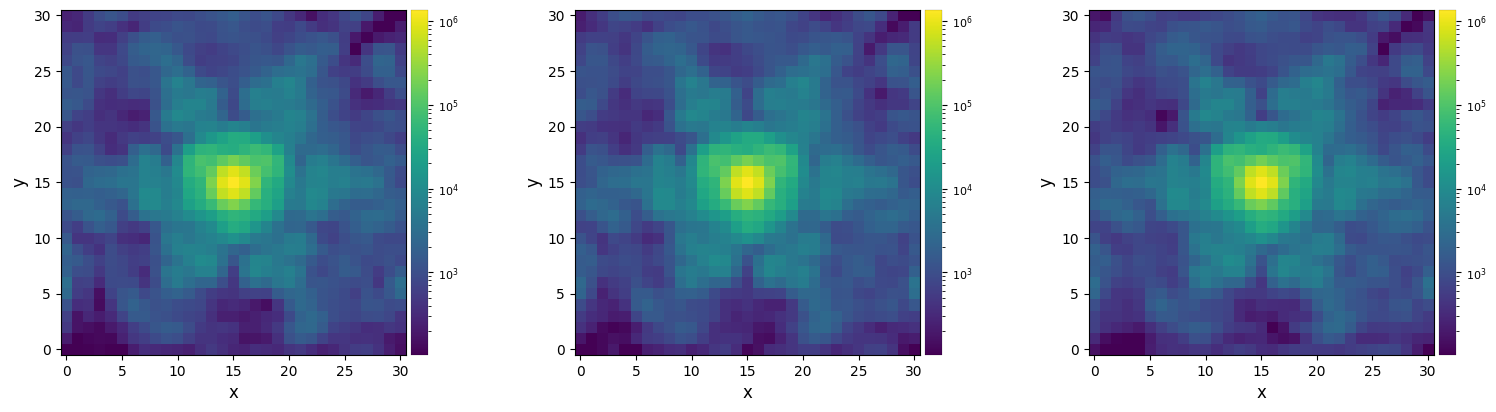

In [160]:
plot_frames((cube_short[0], cube_short[5], cube_short[-1]), log=True, vmin=np.percentile(cube_short, 1))

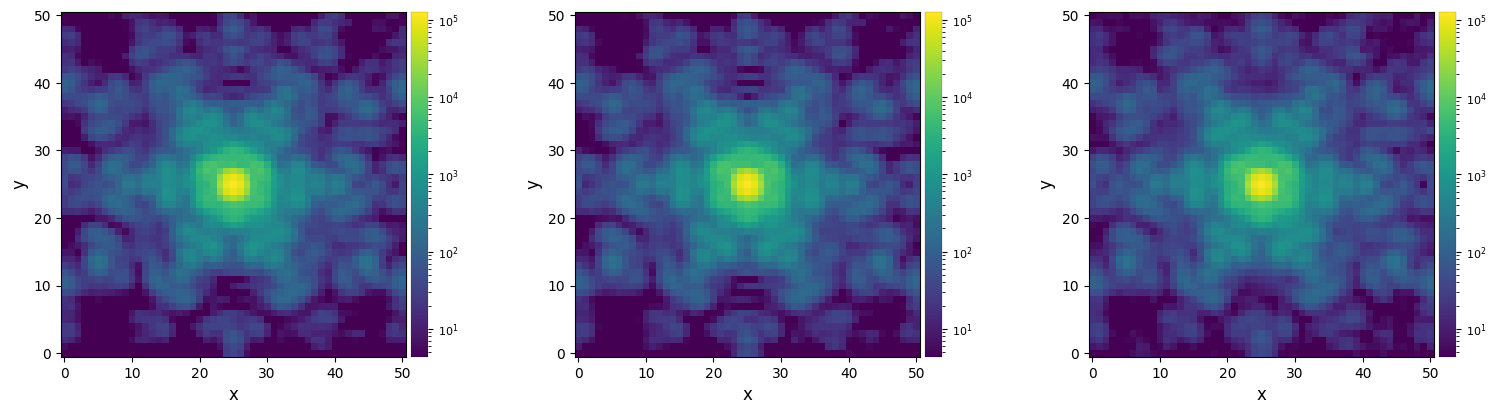

In [161]:
plot_frames((cube_long[0], cube_long[5], cube_long[-1]), log=True, vmin=np.percentile(cube_long, 10))

## 5.7. Roll subtraction

Roll subtraction is the ancestor of angular differential imaging. This strategy consists in acquiring images with a space telescope at two different roll angles, i.e. before and after **rolling** the telescope by a certain amount of rotation. Pair-wise subtraction of the images acquired at the two angles can efficiently remove the stellar halo - while preserving (to some extent) circumstellar signals. This strategy was originally proposed for Hubble observations (Schneider et al. 1998), and is now also available with JWST.

### 5.7.1. Images

Once the data are properly calibrated and pre-processed, performing roll subtraction is as simple as:

In [162]:
roll_img_short = roll_sub(cube_short, pa_short, fwhm_lp_aft=0.8*fwhm_short)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-01-25 09:49:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining
Running time:  0:00:00.013610
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


If provided, the `fwhm_lp_aft` parameter will smooth the resulting image with a Gaussian kernel, the FWHM of which is set to the value of `fwhm_lp_aft` (otherwise None by default). Here we set it to a value slightly smaller than the nominal FWHM.

Let's visualize the result using `plot_frames`:

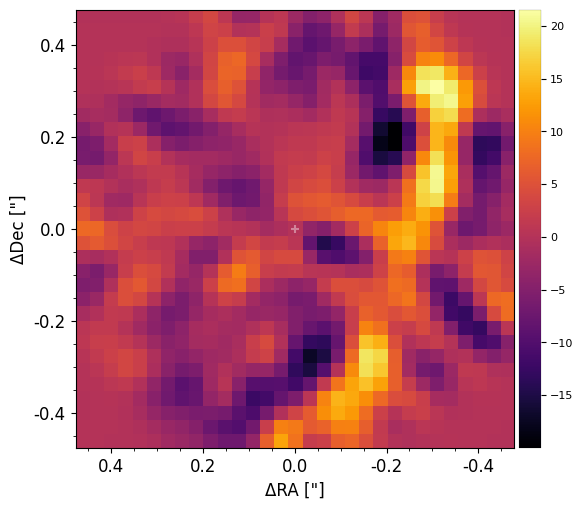

In [163]:
plot_frames(roll_img_short, cmap='inferno', show_center=True, ang_scale=True,
            ang_ticksep=0.2/plsc_short, pxscale=plsc_short)

Those familiar with the PDS 70 system will recognize the bright edge of the outer disk delimiting a ~55 au cavity. Let's use literature knowledge of the orientation of PDS 70, and the latest features of `hciplot.plot_frames` (if needed, upgrade with `pip install hciplot --upgrade`) to plot an ellipse at the expected location of the edge of the cavity:

In [164]:
i_disk = 49. # disk inclination in deg
PA_disk = 249 # position angle of major-axis of the disk, measured east from north.
a_e = 2*(55/114.3)/plsc_short # expected major axis of the ellipse in pixels (conversion factor considers distance of 114.3 pc)
b_e = a_e*np.cos(np.deg2rad(i_disk))
# shift of ellipse center wrt star:
cy, cx = frame_center(roll_img_short)
A = 0.8 # shift amplitude
dy = A*np.sin(np.deg2rad(PA_disk+90))
dx = A*np.cos(np.deg2rad(PA_disk+90))
sy, sx = cy-dy, cx-dx
#print(dy, dx)

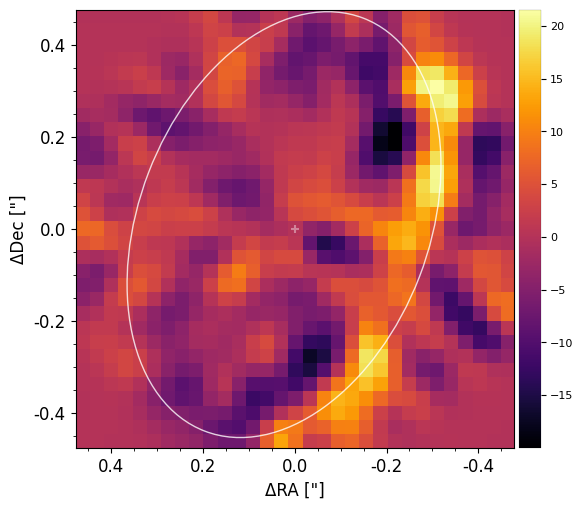

In [165]:
plot_frames(roll_img_short, cmap='inferno', show_center=True, ang_scale=True,
            ang_ticksep=0.2/plsc_short, pxscale=plsc_short,
            ellipse=(sx, sy), ellipse_alpha=0.8, ellipse_color='white',
            ellipse_linestyle='-', ellipse_a=a_e, ellipse_b=b_e,
            ellipse_angle=PA_disk, ellipse_label=False,
            ellipse_label_color='white',)

The ellipse can qualitatively reproduce the bright extended signals, although keep in mind that:
- an ellipse is a very simplistic assumption, considering that the observed scattered light traces small grains close to the surface of the disk, which is known to be flared (as most protoplanetary disks);
- geometric biases affect the image due to the direct pair-wise subtraction of images only rotated by 5º, both containing circumstellar signals. More details about this in the next section.

Let's do the same for the **F480M data**:

In [166]:
roll_img_long = roll_sub(cube_long, pa_long, fwhm_lp_aft=0.7*fwhm_long)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-01-25 09:49:39
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining
Running time:  0:00:00.022451
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


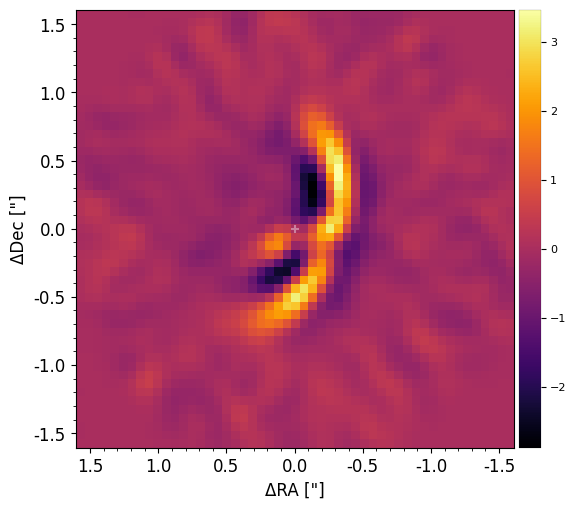

In [167]:
plot_frames(roll_img_long, cmap='inferno', show_center=True, ang_scale=True,
            ang_ticksep=0.5/plsc_long, ang_ticksep_minor=0.1/plsc_long, pxscale=plsc_long)

While some tentative compact sources could already be seen in the F187N image, these appear more clearly in the F480M image (modulo stronger geometric biases - whose most noticeable signatures are the spurious negative signals along the bright edge of the disk). Let's plot where are the predicted locations for protoplanets b and c at the epoch of our observations, based on the orbital fits made in Wang et al. (2021a) - reported on the platform **whereistheplanet** (Wang et al. 2021b).

In [168]:
# whereistheplanet predictions:
dx_b_as = -0.114109 # arcsec
dy_b_as = -0.105187 # arcsec
dx_c_as = 0.209844 # arcsec
dy_c_as = -0.000248 # arcsec

In [169]:
ccys, ccxs = frame_center(roll_img_short)
cx_bs = ccxs+dx_b_as/plsc_short
cy_bs = ccys+dy_b_as/plsc_short
cx_cs = ccxs+dx_c_as/plsc_short
cy_cs = ccys+dy_c_as/plsc_short

In [170]:
ccyl, ccxl = frame_center(roll_img_long)
cx_bl = ccxl+dx_b_as/plsc_long
cy_bl = ccyl+dy_b_as/plsc_long
cx_cl = ccxl+dx_c_as/plsc_long
cy_cl = ccyl+dy_c_as/plsc_long

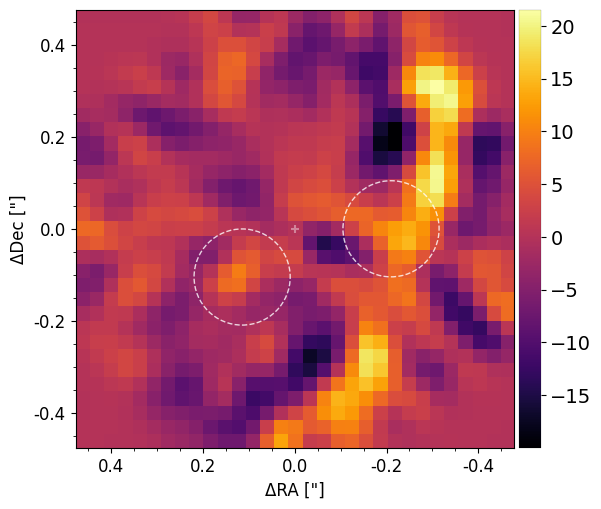

In [171]:
plot_frames(roll_img_short, pxscale=plsc_short, ang_scale=True, ang_ticksep=0.2/plsc_short, 
            circle=((cx_bs, cy_bs),(cx_cs, cy_cs)), circle_linestyle='--', circle_radius=fwhm_short, 
            cmap='inferno', show_center=True, colorbar_ticksize=14)

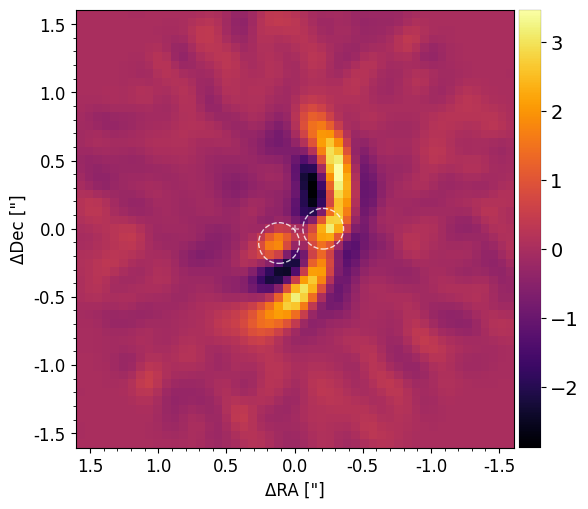

In [172]:
plot_frames(roll_img_long, pxscale=plsc_long, ang_scale=True, ang_ticksep=0.5/plsc_long, 
            ang_ticksep_minor=0.1/plsc_long, circle=((cx_bl, cy_bl),(cx_cl, cy_cl)),
            circle_linestyle='--', circle_radius=fwhm_long/1.8, 
            cmap='inferno', show_center=True, colorbar_ticksize=14)

### 5.7.2. Optimal disk parameters through NEGFD

An ellipse is a too simplistic assumption for the outer disk. A radiative transfer disk model can provide a much more accurate representation of the observations. Such models have recently been published for PDS 70 in Portilla-Revelo et al. (2022; 2023), with the aim of reproducing all available observations (including the SED, and images obtained with ALMA and with polarised IR intensity). A couple of parameters are still loosely constrained but may have an impact in total intensity observations though, such as the $\alpha$ parameter associated to turbulence - which may affect dust settling - and the minimum grain size to consider - let's call it $a_{\rm min}$. 

In order to find an optimal disk, we need a figure of merit. This will be the absolute residuals in a certain area of the image containing disk signals. Such binary mask was defined to cover most of the outer disk signal towards the south west of the star - avoiding the predicted locations of the planets and the north west part of the disk, where both literature and our roll subtraction images suggest that an asymmetry is present (not captured in our RT models).

In [173]:
bin_mask = open_fits(binary_mask_long)

FITS HDU-0 data successfully loaded. Data shape: (51, 51)


Let's visualize the extent of the mask by applying it to the roll subtraction processed image:

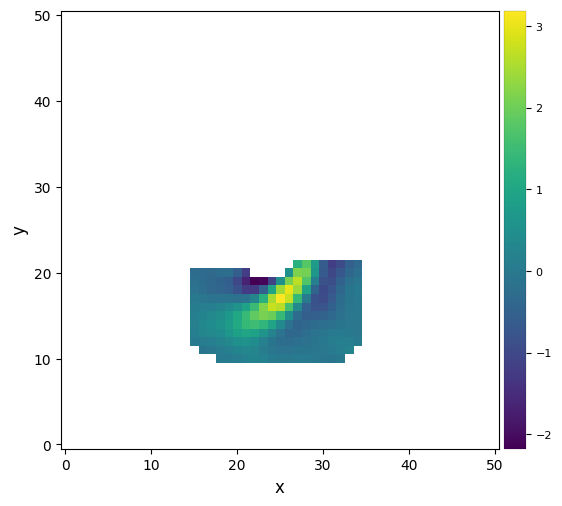

In [174]:
plot_frames(bin_mask*roll_img_long)

Let's now load the grid of radiative transfer model images of the PDS 70 disk. This is a 4D array, with the first 2 dimensions probing different alpha (Shakura-Sunyaev turbulent parameter) and $a_{\rm min}$ (minimum grain size in the distribution) values, respectively.

In [175]:
disk_model_grid = open_fits(modelname_long)

FITS HDU-0 data successfully loaded. Data shape: (2, 5, 49, 49)


Let's first have a quick look at the edge cases of the disk model grid:

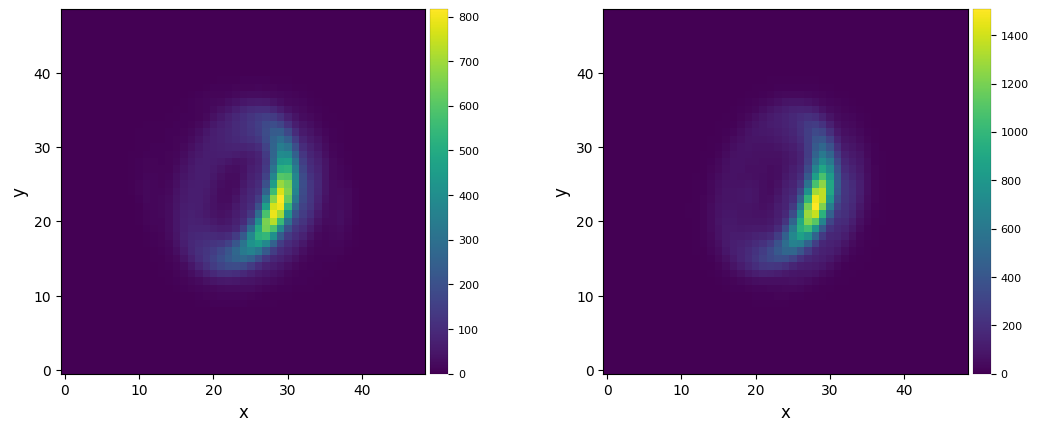

In [176]:
plot_frames((disk_model_grid[0,0], disk_model_grid[-1,-1]))

The above already gives an idea of the kind of geometric biases affecting the images processed with roll subtraction. Note that the models do not include the planets, just the outer disk.

Let's consider the first model of the grid and see whether it yields a good match to our observations. This can be done with `firstguess_fd`. We also consider a couple of other additional degrees of freedom, including x/y shifts (hence the 2 pixels smaller dimensions for the model images), flux scaling, spatial scaling, and rotation of the model images (all free parameters by default).

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-01-25 10:07:59
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Flux estimation for xy shift [0,0], 0deg rotation and 1.0x spatial scaling is running ...
Step | flux    | chi2r
1/20   0.010   0.242
2/20   0.016   0.241
3/20   0.026   0.239
4/20   0.043   0.237
5/20   0.070   0.233
6/20   0.113   0.227
7/20   0.183   0.217
8/20   0.298   0.203
9/20   0.483   0.184
10/20   0.785   0.175
11/20   1.274   0.217
12/20   2.069   0.344
13/20   3.360   0.580


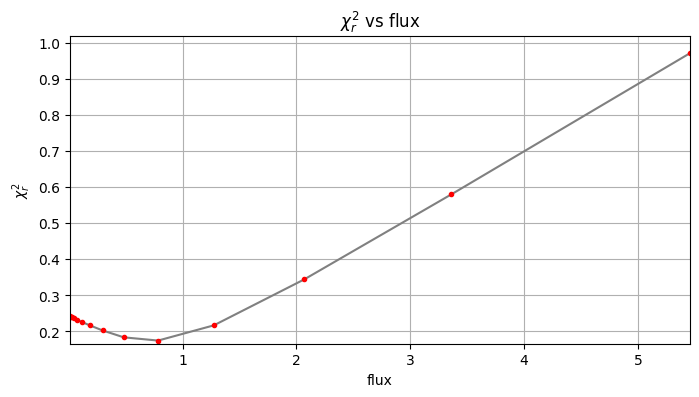

Preliminary shift, rotation and scaling guess: (x, y, theta, scal) = (0.0, 0.0, 0.0, 1.0)
Preliminary flux guess: 0.8
Simplex Nelder-Mead minimization, running ...
Initial guess:  (0, 0, 0, 1.0, 0.7847599703514611)

Nelder-Mead minimization is running...
 final_simplex: (array([[1.97527725e-04, 8.95968067e-05, 2.06038969e-04, 9.12820984e-01,
        8.12174959e-01],
       [1.97511694e-04, 8.95909794e-05, 2.06013649e-04, 9.12820999e-01,
        8.12175622e-01],
       [1.97516123e-04, 8.95895788e-05, 2.06022687e-04, 9.12821809e-01,
        8.12175503e-01],
       [1.97511611e-04, 8.95889574e-05, 2.06015506e-04, 9.12821292e-01,
        8.12175413e-01],
       [1.97513314e-04, 8.95906816e-05, 2.06019843e-04, 9.12821642e-01,
        8.12175386e-01],
       [1.97500453e-04, 8.95777878e-05, 2.05996124e-04, 9.12821696e-01,
        8.12175485e-01]]), array([0.15293484, 0.15293493, 0.15293497, 0.15293499, 0.15293499,
       0.15293501]))
           fun: 0.1529348396115398
       message: 'Opti

In [186]:
# first with non-optimal disk model
algo_options = {'collapse':'mean', 
                'fwhm_lp_aft':0.7*fwhm_long,
                'verbose':False}
res_sum = firstguess_fd(cube_long, pa_long, disk_model=disk_model_grid[0,0], mask_fm=bin_mask, 
                        fmerit='sum', f_range=np.geomspace(0.01, 100, 20), imlib='vip-fft', 
                        plot=True, algo=roll_sub, algo_options=algo_options, full_output=True)
print("Optimal parameters and chi^2 are: {}, respectively".format(res_sum))

The optimal results suggest null shifts and rotation, but smaller spatial scaling (factor 0.91) and some smaller flux scaling (by a factor 0.81). Given the uncertainties involved in extrapolating disk fluxes at different wavelengths and the dependency on (poorly constrained) grain properties, these values are not too bad at all.

`firstguess_fd` is versatile and can accept either a single disk model image or a grid of model images within which it can interpolate. Let's now see what's the best model within the full 4D grid of models. In such case, we also need to specify parameters `grid_params_list` and `labels` which tells the algorithms what are the parameter values probed in the grid, and their label, respectively.

In [187]:
grid_params_list = [[0.001, 0.05],[0.001, 0.0018, 0.0032, 0.0056, 0.01]]
grid_params_labels = ('a_min', 'alpha')

Model interpolation can be made in log or linear space, depending on the value set for `interp_order`: set it to -1 or 1 for log or linear, respectively.

In [188]:
interp_order = 1 # let's keep it to a linear dependency with the disk parameters.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-01-25 10:08:38
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Step | flux    | chi2r
1/20   0.010   0.242
2/20   0.016   0.241
3/20   0.026   0.239
4/20   0.043   0.237
5/20   0.070   0.233
6/20   0.113   0.227
7/20   0.183   0.217
8/20   0.298   0.203
9/20   0.483   0.184
10/20   0.785   0.175
11/20   1.274   0.217
12/20   2.069   0.344
13/20   3.360   0.580


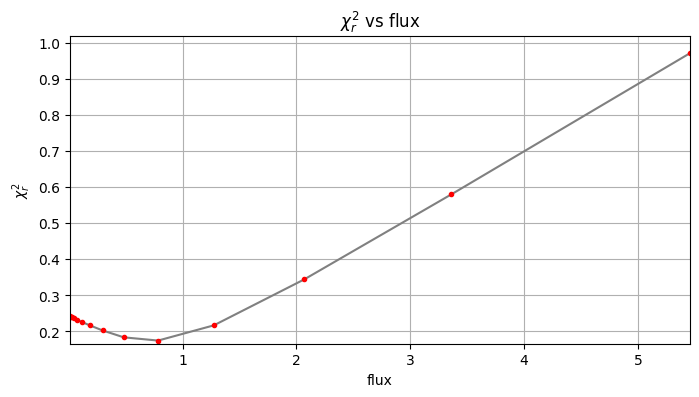

Step | flux    | chi2r
1/20   0.010   0.241
2/20   0.016   0.240
3/20   0.026   0.239
4/20   0.043   0.236
5/20   0.070   0.231
6/20   0.113   0.224
7/20   0.183   0.213
8/20   0.298   0.197
9/20   0.483   0.175
10/20   0.785   0.168
11/20   1.274   0.226
12/20   2.069   0.374
13/20   3.360   0.633


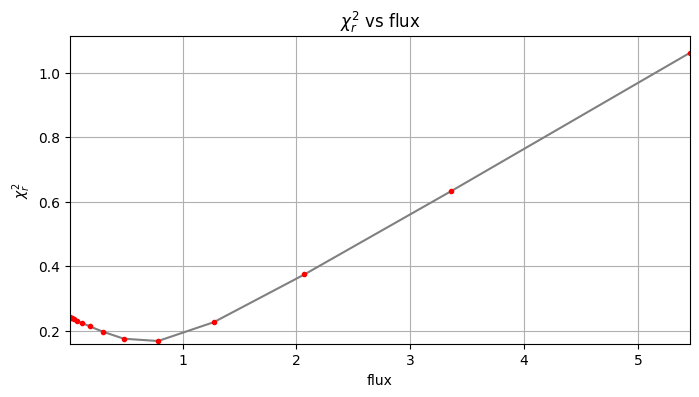

Step | flux    | chi2r
1/20   0.010   0.241
2/20   0.016   0.240
3/20   0.026   0.238
4/20   0.043   0.235
5/20   0.070   0.231
6/20   0.113   0.224
7/20   0.183   0.212
8/20   0.298   0.196
9/20   0.483   0.175
10/20   0.785   0.171
11/20   1.274   0.241
12/20   2.069   0.400
13/20   3.360   0.677


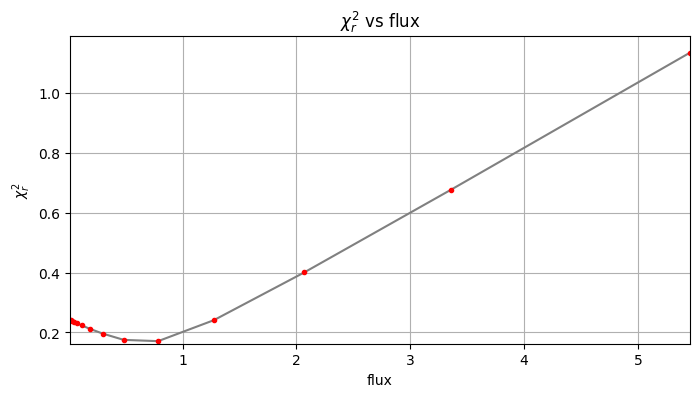

Step | flux    | chi2r
1/20   0.010   0.241
2/20   0.016   0.240
3/20   0.026   0.238
4/20   0.043   0.235
5/20   0.070   0.230
6/20   0.113   0.221
7/20   0.183   0.209
8/20   0.298   0.190
9/20   0.483   0.167
10/20   0.785   0.173
11/20   1.274   0.261
12/20   2.069   0.443


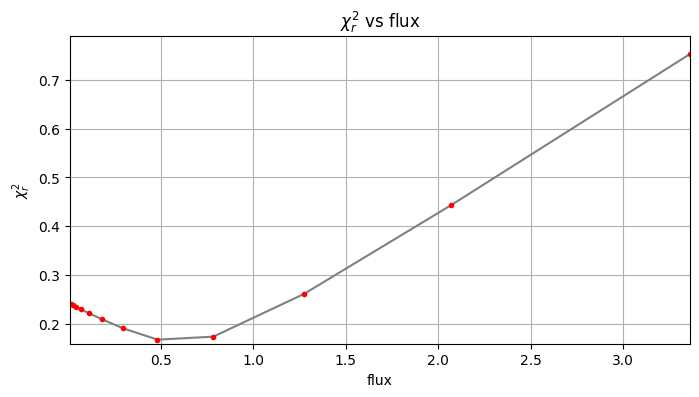

Step | flux    | chi2r
1/20   0.010   0.242
2/20   0.016   0.241
3/20   0.026   0.239
4/20   0.043   0.237
5/20   0.070   0.233
6/20   0.113   0.227
7/20   0.183   0.218
8/20   0.298   0.203
9/20   0.483   0.182
10/20   0.785   0.159
11/20   1.274   0.184
12/20   2.069   0.298
13/20   3.360   0.510


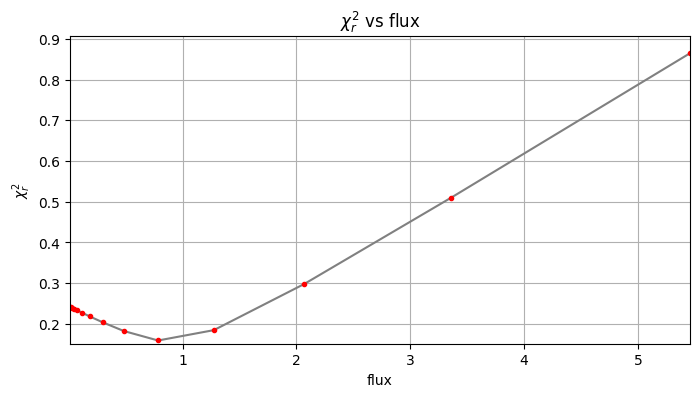

Step | flux    | chi2r
1/20   0.010   0.242
2/20   0.016   0.241
3/20   0.026   0.239
4/20   0.043   0.237
5/20   0.070   0.233
6/20   0.113   0.226
7/20   0.183   0.216
8/20   0.298   0.200
9/20   0.483   0.178
10/20   0.785   0.160
11/20   1.274   0.199
12/20   2.069   0.317
13/20   3.360   0.533


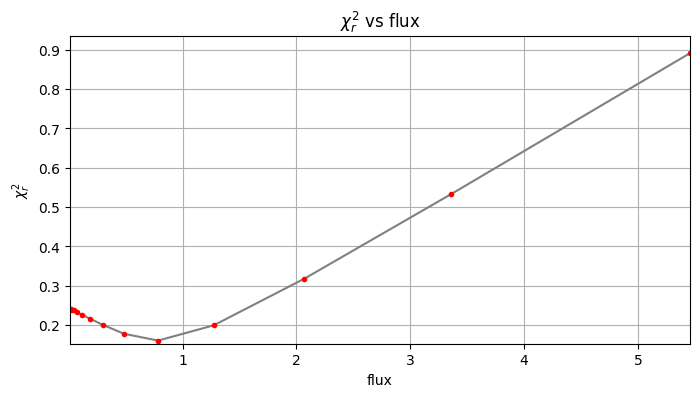

Step | flux    | chi2r
1/20   0.010   0.241
2/20   0.016   0.240
3/20   0.026   0.239
4/20   0.043   0.236
5/20   0.070   0.231
6/20   0.113   0.224
7/20   0.183   0.213
8/20   0.298   0.196
9/20   0.483   0.171
10/20   0.785   0.157
11/20   1.274   0.206
12/20   2.069   0.341
13/20   3.360   0.575


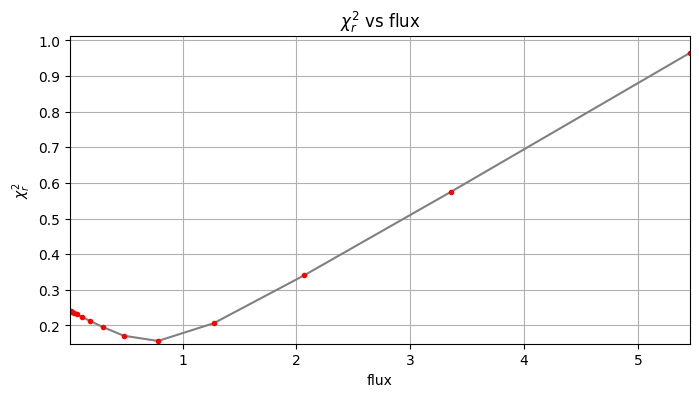

Step | flux    | chi2r
1/20   0.010   0.241
2/20   0.016   0.239
3/20   0.026   0.237
4/20   0.043   0.234
5/20   0.070   0.228
6/20   0.113   0.219
7/20   0.183   0.204
8/20   0.298   0.181
9/20   0.483   0.154
10/20   0.785   0.169
11/20   1.274   0.263
12/20   2.069   0.446


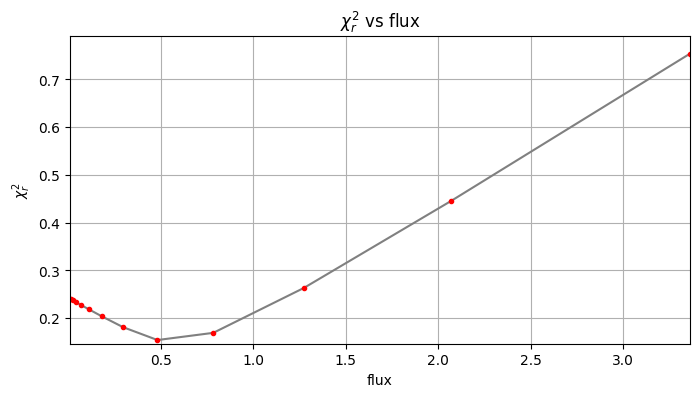

Step | flux    | chi2r
1/20   0.010   0.241
2/20   0.016   0.240
3/20   0.026   0.238
4/20   0.043   0.235
5/20   0.070   0.229
6/20   0.113   0.221
7/20   0.183   0.208
8/20   0.298   0.187
9/20   0.483   0.160
10/20   0.785   0.159
11/20   1.274   0.236
12/20   2.069   0.397
13/20   3.360   0.674


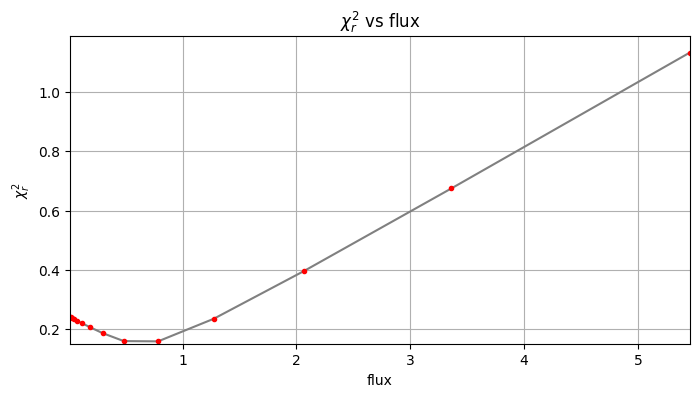

Step | flux    | chi2r
1/20   0.010   0.241
2/20   0.016   0.239
3/20   0.026   0.237
4/20   0.043   0.233
5/20   0.070   0.226
6/20   0.113   0.216
7/20   0.183   0.199
8/20   0.298   0.175
9/20   0.483   0.151
10/20   0.785   0.186
11/20   1.274   0.298
12/20   2.069   0.506


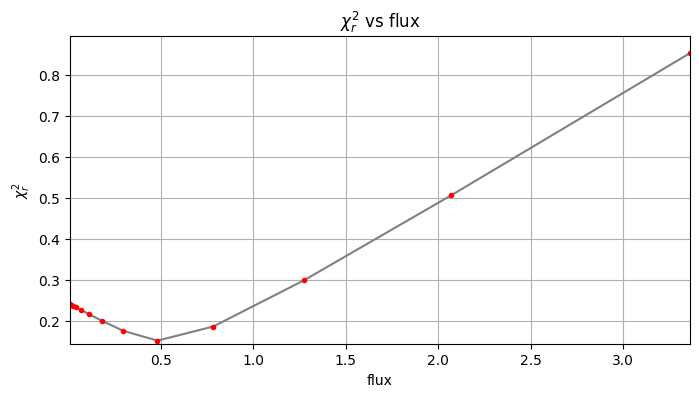

Preliminary indices of best model in disk model grid: (1, 4). Preliminary shift, rotation and scaling guess: (x, y, theta, scal) = (0.0, 0.0, 0.0, 1.0)
Preliminary flux guess: 0.5
Simplex Nelder-Mead minimization, running ...
Initial guess:  [0.05, 0.01, 0, 0, 0, 1.0, 0.4832930238571752]

Nelder-Mead minimization is running...
 final_simplex: (array([[ 5.00000000e-02,  1.00000000e-02,  1.30507849e-18,
         1.30507849e-18,  1.30507849e-18,  1.00000000e+00,
         4.83293024e-01],
       [ 5.00000000e-02,  1.00000000e-02,  8.54515681e-19,
         8.54515681e-19,  8.54515681e-19,  1.00000000e+00,
         4.83293024e-01],
       [ 5.00000000e-02,  1.00000000e-02,  1.63208796e-18,
         1.63208796e-18,  1.63208796e-18,  1.00000000e+00,
         4.83293024e-01],
       [ 5.00000000e-02,  1.00000000e-02,  2.09839880e-18,
         2.09839880e-18,  2.09839880e-18,  1.00000000e+00,
         4.83293024e-01],
       [ 5.00000000e-02,  1.00000000e-02,  2.69794132e-18,
         2.69794132

In [189]:
algo_options = {'collapse':'mean', 
                'fwhm_lp_aft':0.7*fwhm_long,
                'verbose':False}
res_sum_grid = firstguess_fd(cube_long, pa_long, disk_model=disk_model_grid, mask_fm=bin_mask,
                        grid_params_list=grid_params_list, grid_params_labels=grid_params_labels, 
                        interp_order=interp_order, fmerit='sum', f_range=np.geomspace(0.01, 100, 20),
                        imlib='vip-fft', plot=True, algo=roll_sub, algo_options=algo_options, full_output=True)
print("Optimal parameters and chi^2 are: {}, respectively".format(res_sum_grid))

This time the optimal parameters are found to be: a_min$\approx$0.05µm, alpha$\approx$0.01, no shift and rotation, spatial scaling of 1 and flux scaling of $\sim$0.5. Let's now compare how the residuals look like after subtraction of the optimal model.
First define the tuple of optimal parameters, this is the output of the `firstguess_fd` function, less the last element which corresponds to the chi^2.

In [190]:
opt_params_sum_single = res_sum[:-1] # last element in res_sum_grid is chi^2
opt_params_sum_grid = res_sum_grid[:-1] # last element in res_sum_grid is chi^2

In [ ]:
interp_disk_grid = interpolate_model(df_params_sum_grid[:2], grid_params_list, final_disk_cube, interp_order=-1)

The disk parameters are degenerate. If your purpose is the characterization of the disk and grain properties (keeping in mind the uncertainties involved), it'd be recommended to adopt a MCMC approach and a larger grid of input disk parameters. This is beyond the scope of this study, where our only goal is to have the best possible subtraction of the outer disk for protoplanet characterization (and identification of outstanding residual signals).

### 5.7.3 Optimal planet parameters through NEGFC

In [ ]:
r_0H, theta_0H, f_0H = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, planets_xy_coord=[xy_test], 
                               fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco,
                               fmerit='hessian', mu_sigma=None, ndet=3,
                               aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                               simplex=True, plot=True, verbose=True)

## 6.2. Examples of disks

Let's assume we want to create a synthetic image of 200px, containing a disk around a star located at 80 a.u., observed with SPHERE/IRDIS (pixel scale 12.25 mas).

In [3]:
pixel_scale=0.01225 # pixel scale in arcsec/px
dstar= 80 # distance to the star in pc
nx = 200 # number of pixels of your image in X
ny = 200 # number of pixels of your image in Y

### 6.2.1. Symmetric pole-on disk

For a pole-on disk, $i_\text{tilt}=0^\circ$.

For a symmetric disk, $e=0$ and the position angle (pa) and argument of pericenter ($\omega$) have no impact.

We choose a semi-major axis of 70 a.u., a vertical profile with a gaussian distribution ($\gamma=2$), a reference scale height of 3 a.u. at the semi-major axis of the disk, and inner and outer exponent $\alpha_{in}=12$ and $\alpha_{out}=-12$

In [4]:
itilt = 0. # inclination of your disk in degrees
a = 70. # semimajoraxis of the disk in au 
ksi0 = 3. # reference scale height at the semi-major axis of the disk
gamma = 2. # exponant of the vertical exponential decay
alpha_in = 12
alpha_out = -12
beta = 1

Then create your disk model

In [5]:
fake_disk1 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws','ain':alpha_in,'aout':alpha_out,
                                              'a':a,'e':0.0,'ksi0':ksi0,'gamma':gamma,'beta':beta},
                                spf_dico={'name':'HG', 'g':0., 'polar':False}, 
                                flux_max=1.)

The method `compute_scattered_light` returns the synthetic image of the disk.

In [6]:
fake_disk1_map = fake_disk1.compute_scattered_light()

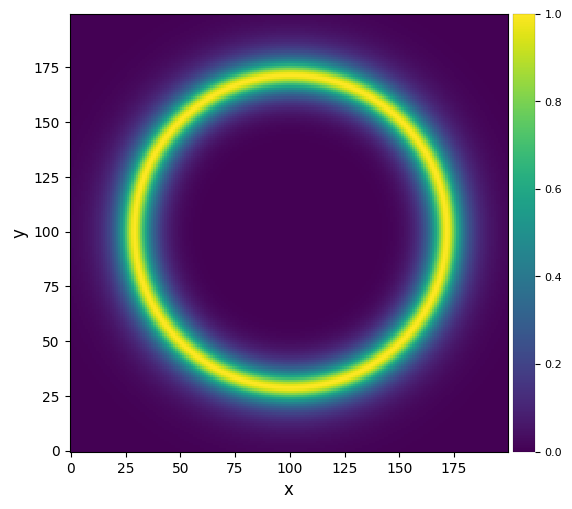

In [7]:
plot_frames(fake_disk1_map, grid=False, size_factor=6)

You can print some info on the geometrical properties of the model, the dust distribution parameters, the numerical integration parameters and the phase function parameters (detailed later). 

This can be useful because, in addition to reminding all the parameters used in the model, it also computes some properties such as the radial FWHM of the disk.

In [8]:
fake_disk1.print_info()

-----------------------------------
Geometrical properties of the image
-----------------------------------
Image size: 200 px by 200 px
Pixel size: 0.0123 arcsec/px or 0.98 au/px
Distance of the star 80.0 pc
From -98.0 au to 97.0 au in X
From -98.0 au to 97.0 au in Y
Position angle of the disc: 0.00 degrees
Inclination 0.00 degrees
Argument of pericenter 0.00 degrees
Maximum flux of the disk 1.00
----------------------------
Dust distribution parameters
----------------------------
Reference semi-major axis: 70.0au
Semi-major axis at maximum dust density in plane z=0: 70.0au (same as ref sma if ain=-aout)
Semi-major axis at half max dust density: 64.2au / 76.3au for the inner/outer edge, or a FWHM of 12.1au
Semi-major axis at maximum dust surface density: 70.2au (same as ref sma if ain=-aout)
Ellipse p parameter: 70.0au
Ellipticity: 0.000
Inner slope: 12.00
Outer slope: -12.00
Density at the reference semi-major axis: 1.000e+00 (arbitrary unit
Scale height: 3.00 au at 70.00
Vertical p

As a side note, if $\alpha_{in} \ne \alpha_{out}$, then the peak surface density of the disk is not located at the reference radius $a$.

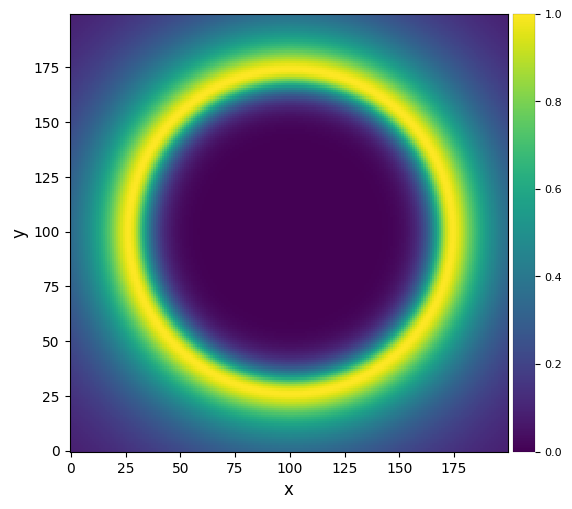

In [9]:
fake_disk1 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':-3,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':0., 'polar':False},
                                flux_max=1.)
fake_disk1_map = fake_disk1.compute_scattered_light()
plot_frames(fake_disk1_map, grid=False, size_factor=6)

In [10]:
fake_disk1.print_info()

-----------------------------------
Geometrical properties of the image
-----------------------------------
Image size: 200 px by 200 px
Pixel size: 0.0123 arcsec/px or 0.98 au/px
Distance of the star 80.0 pc
From -98.0 au to 97.0 au in X
From -98.0 au to 97.0 au in Y
Position angle of the disc: 0.00 degrees
Inclination 0.00 degrees
Argument of pericenter 0.00 degrees
Maximum flux of the disk 1.00
----------------------------
Dust distribution parameters
----------------------------
Reference semi-major axis: 70.0au
Semi-major axis at maximum dust density in plane z=0: 73.3au (same as ref sma if ain=-aout)
Semi-major axis at half max dust density: 65.0au / 95.9au for the inner/outer edge, or a FWHM of 30.9au
Semi-major axis at maximum dust surface density: 74.5au (same as ref sma if ain=-aout)
Ellipse p parameter: 70.0au
Ellipticity: 0.000
Inner slope: 12.00
Outer slope: -3.00
Density at the reference semi-major axis: 1.000e+00 (arbitrary unit
Scale height: 3.00 au at 70.00
Vertical pr

### 6.2.2. Inclined symmetric disk

In [11]:
itilt = 76 # inclination of your disk in degreess

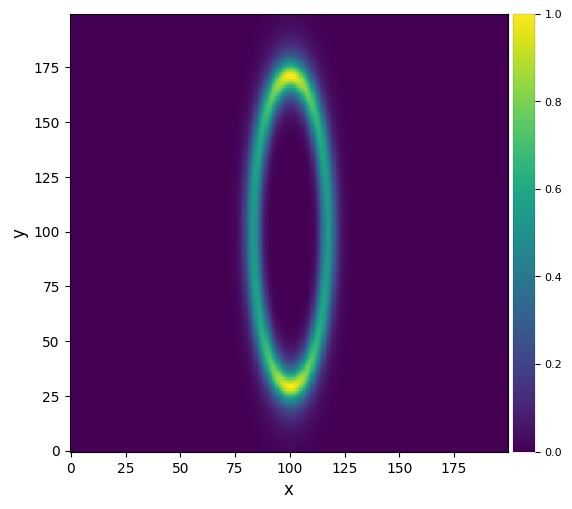

In [12]:
fake_disk2 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':0., 'polar':False},
                                flux_max=1.)
fake_disk2_map = fake_disk2.compute_scattered_light()
plot_frames(fake_disk2_map, grid=False, size_factor=6)

The position angle of the disk is 0 (e.g. north).  The phase function is asymmetric, the reason why the north and south ansae appear brighter is because the disk is not flat: it has a certain scale height and there is more dust intercepted along the line of sight in the ansae.

Note that we decided here to normalize the disk to a maximum brightness of 1, using the option `flux_max=1.`. This is not the only option available and you can decide to paramterize $\rho_0$ instead, using the keyword `dens_at_r0` which directly specifies $\rho_0$.

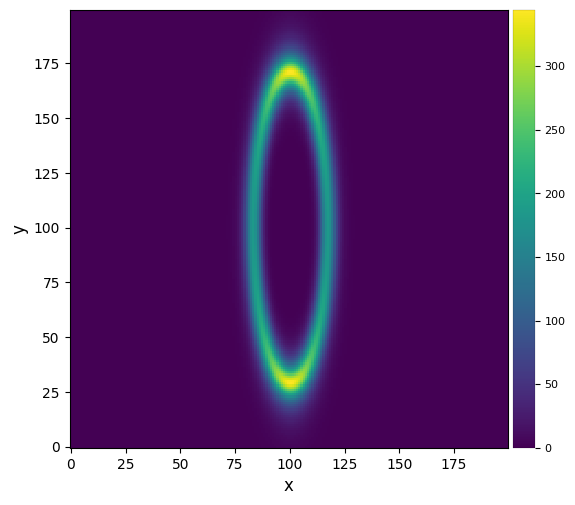

In [13]:
fake_disk2 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta,
                                              'dens_at_r0':1e6},
                                spf_dico={'name':'HG', 'g':0, 'polar':False})
fake_disk2_map = fake_disk2.compute_scattered_light()
plot_frames(fake_disk2_map, grid=False, size_factor=6)

Warning ! The code does not handle perfectly edge-on disks. There is a maximum inclination close to edge-on beyond which it cannot create an image. In practice this is not a limitation as the convolution by the PSF always makes it impossible to disentangle between a close to edge-on disk and a perfectly edge-on disk.

Warning the disk is too close to edge-on
The inclination was changed from 90.00 to 87.58


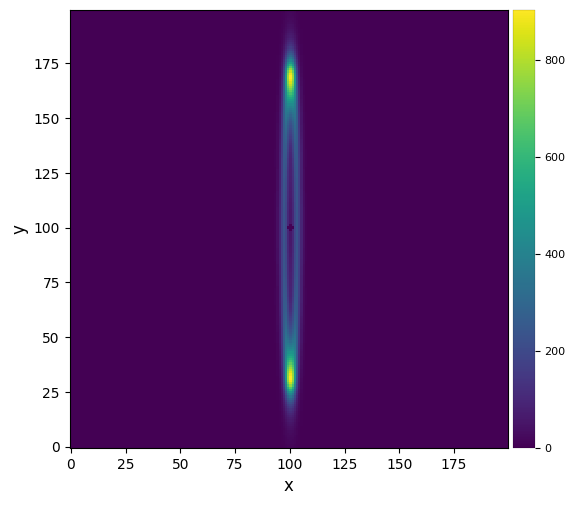

In [14]:
fake_disk2 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=90, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':2, 'gamma':gamma, 'beta':beta, 
                                              'dens_at_r0':1e6},
                                spf_dico={'name':'HG', 'g':0, 'polar':False})
fake_disk2_map = fake_disk2.compute_scattered_light()
plot_frames(fake_disk2_map, grid=False, size_factor=6)

### 6.2.3. Inclined symmetric disk with anisotropy of scattering

#### 6.2.3.1. Simple Henyey-Greenstein phase function

We parametrize the phase function by a Henyey Greenstein phase function, with an asymmetry parameter g. An isotropic phase function has $g=0$, forward scattering is represented by $0<g\leq1$ and backward scattering is represented by $-1\leq g<0$

In [15]:
g=0.4

In [16]:
fake_disk3 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':g, 'polar':False},
                                flux_max=1.)

You can plot how the phase function look like:

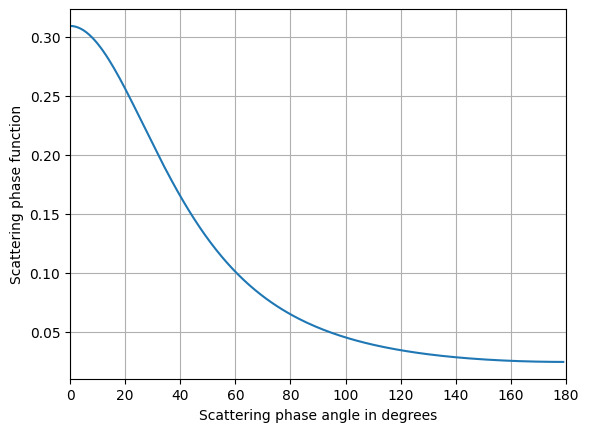

In [17]:
fake_disk3.phase_function.plot_phase_function()

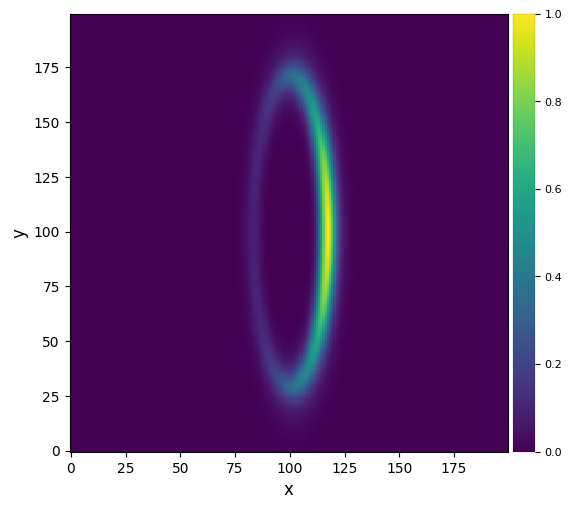

In [18]:
fake_disk3_map = fake_disk3.compute_scattered_light()
plot_frames(fake_disk3_map, grid=False, size_factor=6)

The forward side is brighter. 

#### 6.2.3.2. Double Henyey-Greenstein phase function

A double Henyey Greenstein (HG) phase function is simply a linear combination of 2 simple HG phase function. It is therefore parametrized by $g_1$ and $g_2$ the 2 asymmetry parameters of each HG and the weight (between 0 and 1) of the first HG phase function. Typically a double HG is used to represent a combination of forward scattering ($g_1>0$) and backward scattering ($g_2<1$)

In [19]:
g1=0.6
g2=-0.4
weight1=0.7

In [20]:
fake_disk4 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'DoubleHG', 'g':[g1,g2], 'weight':weight1,
                                          'polar':False},
                                flux_max=1)

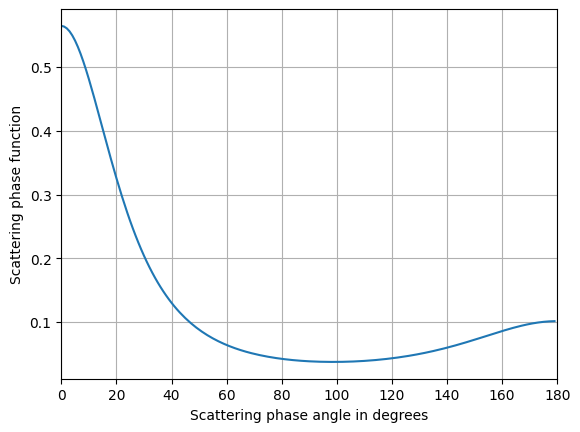

In [21]:
fake_disk4.phase_function.plot_phase_function()

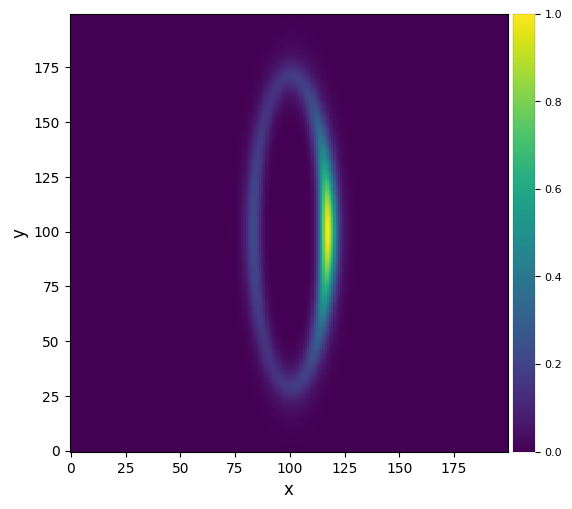

In [22]:
fake_disk4_map = fake_disk4.compute_scattered_light()
plot_frames(fake_disk4_map, grid=False, size_factor=6)

#### 6.2.3.3. Custom phase function

In some cases, a HG phase function (simple or double) cannot represent well the behaviour of the dust. The code is modular and you can propose new prescriptions for the phase functions if you need, or you can also create a custom phase function.

In [23]:
kind='cubic' #kind must be either "linear", "nearest", "zero", "slinear", "quadratic" or "cubic"
spf_dico = dict({'phi':[0,  60,  90, 120, 180],
                 'spf':[1, 0.4, 0.3, 0.3, 0.5],
                 'name':'interpolated', 'polar':False, 'kind':kind})

In [24]:
fake_disk5 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico=spf_dico, flux_max=1)

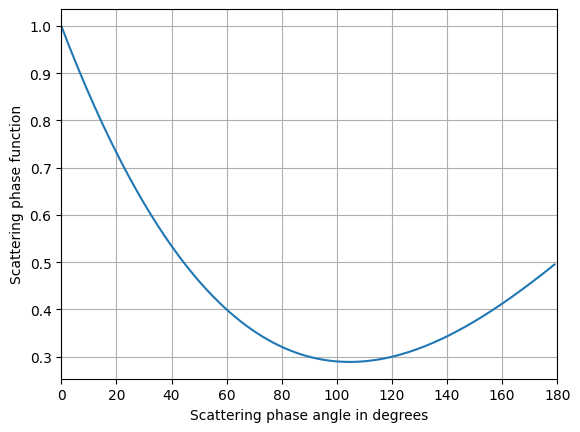

In [25]:
fake_disk5.phase_function.plot_phase_function()

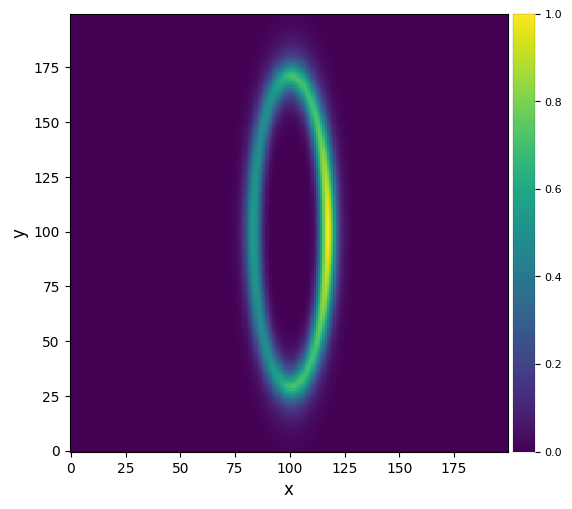

In [26]:
fake_disk5_map = fake_disk5.compute_scattered_light()
plot_frames(fake_disk5_map, grid=False, size_factor=6)

#### 6.2.3.4. Representing a polarised phase function

If you are trying to reproduce the polarised intensity of a disk (for instance Stokes $Q_\phi$ image), you may want to add on top of the scattering phase function, a modulation representing the degree of linear polarisation.

This can be done by setting the `polar` keyword to True and in this case, the model assumes a Rayleigh-like degree of linear polarisation parametrized by $(1-(\cos \phi)^2) / (1+(\cos \phi)^2)$ where $\phi$ is the scattering angle.

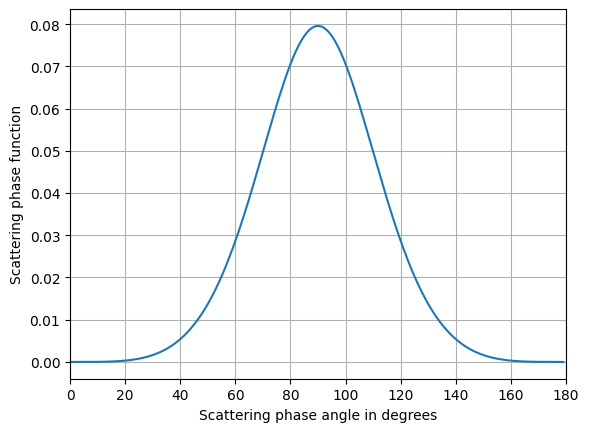

In [27]:
fake_disk6 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':0.0, 'ksi0':ksi0, 'gamma':gamma, 
                                              'beta':beta, 'dens_at_r0':1e6},
                                spf_dico={'name':'HG', 'g':0, 'polar':True})
fake_disk6.phase_function.plot_phase_function()

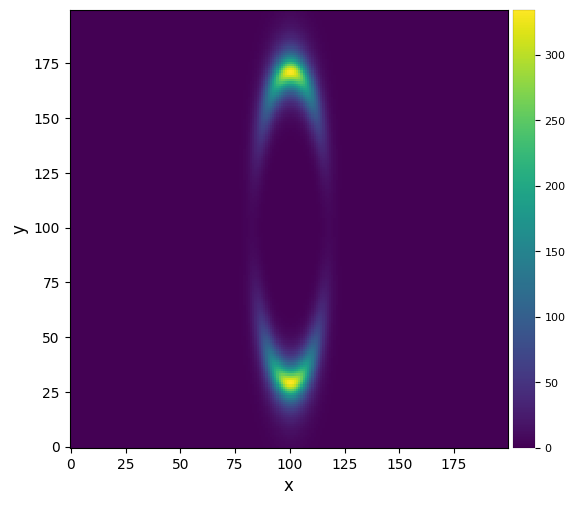

In [28]:
fake_disk6_map = fake_disk6.compute_scattered_light()
plot_frames(fake_disk6_map, grid=False, size_factor=6)

You can combine this Rayleigh-like degree of linear polarisation with any phase function (simple HG, double HG or custom type).

### 6.2.4. Asymmetric disk

Be careful here !

There is no consensus in the community on how to parametrize an eccentric dust distribution, so keep in mind that the convention described in section 1.2 is only one way to do so, but does not mean the dust density distribution in an eccentric disk follows this prescription. For instance, around the pericenter particle velocities are higher and one expects more collision to happen which can create an overdensity of particles compared to other regions of the disk. Conversely, particles stay longer at the apocenter because of Kepler's third law, which means that one could also expect a higher density at apocenter... All these physical phenomena are not described in this model.

Let's start woth a pole-on disk to be insensitive to phase function effects

In [29]:
e=0.4 # eccentricity in degrees
omega=30 # argument of pericenter

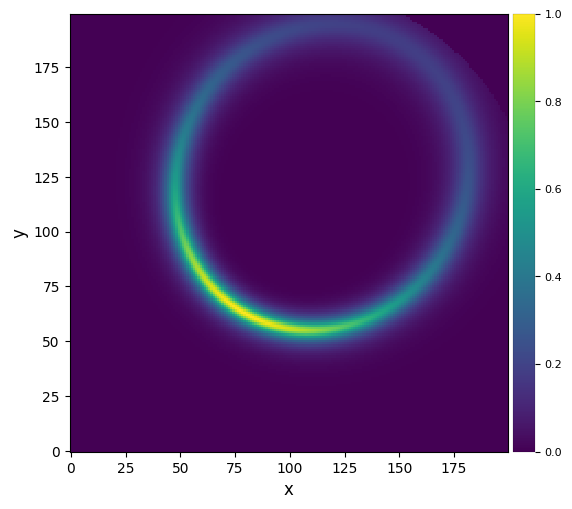

In [30]:
fake_disk7 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=0, omega=omega, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':e, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':g, 'polar':False},
                                flux_max=1.)
fake_disk7_map = fake_disk7.compute_scattered_light()
plot_frames(fake_disk7_map, grid=False, size_factor=6)

The brightness asymmetry here is entirely due to the fact that the brightness at one point in the disk is inversely proportional to the squared distance to the star.

Once you incline the disk, you start seeing the competing effect of the phase function and eccentricity.

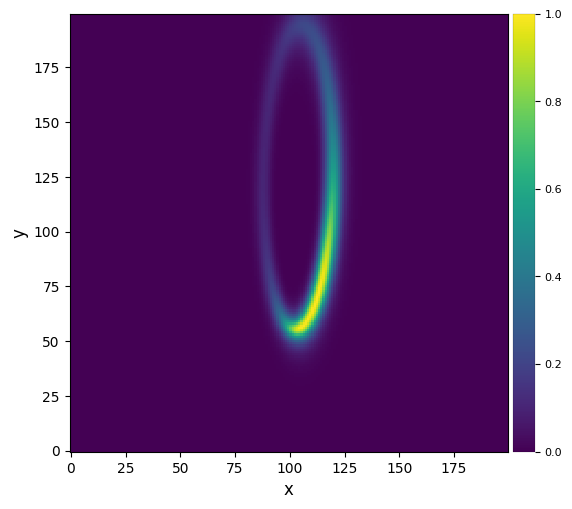

In [31]:
fake_disk7 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=omega, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws', 'ain':alpha_in, 'aout':alpha_out,
                                              'a':a, 'e':e, 'ksi0':ksi0, 'gamma':gamma, 'beta':beta},
                                spf_dico={'name':'HG', 'g':g, 'polar':False},
                                flux_max=1.)
fake_disk7_map = fake_disk7.compute_scattered_light()
plot_frames(fake_disk7_map, grid=False, size_factor=6)

## 6.3. Forward modeling of disks

Let's start from our inclined simple HG symmeric disk `fake_disk3_map` and assume we observe this disk as part of an ADI sequence of 30 images

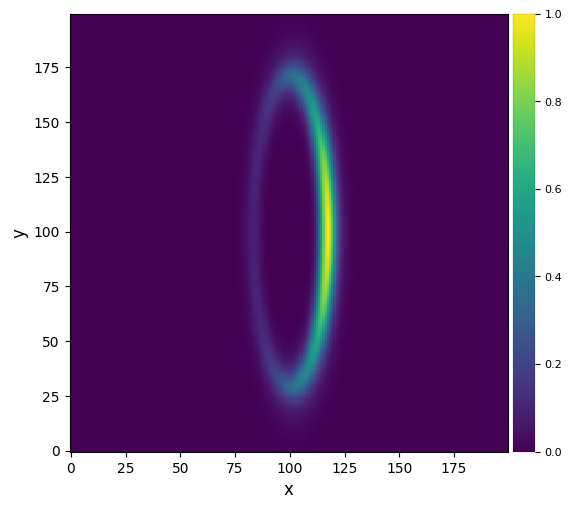

In [32]:
plot_frames(fake_disk3_map, grid=False, size_factor=6)

In [33]:
nframes = 30
# we assume we have 60º of parallactic angle rotation centered around meridian
parang_amplitude = 60
derotation_angles = np.linspace(-parang_amplitude/2, parang_amplitude/2, nframes)

In [34]:
start = time_ini()
cube_fake_disk3 = cube_inject_fakedisk(fake_disk3_map, -derotation_angles, imlib='vip-fft')
timing(start)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 01:21:53
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:02.807283
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


`cube_fake_disk3` is now a cube of 30 frames, where the disk has been injected at the correct position angle.

In [35]:
cube_fake_disk3.shape

(30, 200, 200)

Let's visualize the first, middle and last image of the cube.

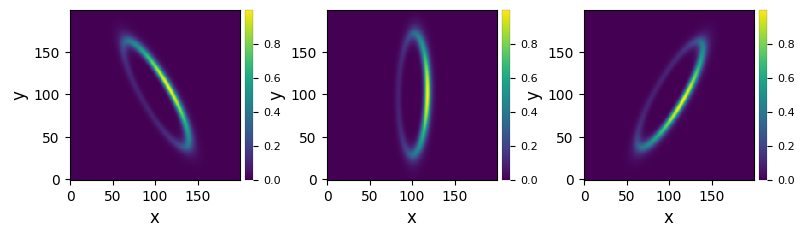

In [36]:
plot_frames((cube_fake_disk3[0], cube_fake_disk3[nframes//2], cube_fake_disk3[nframes-1]), 
            grid=False, size_factor=3)

We can now process this cube with median-ADI for instance:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 01:21:56
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:02.647476
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


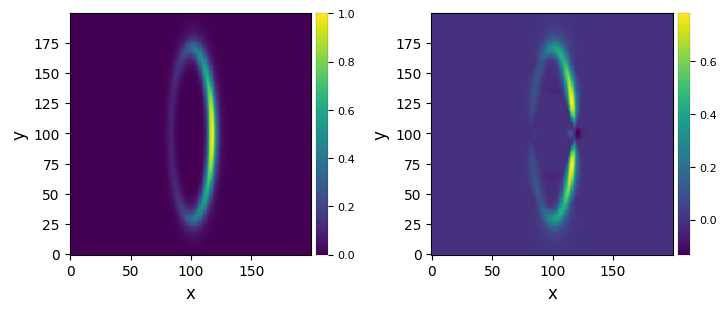

In [37]:
cadi_fake_disk3 = median_sub(cube_fake_disk3, derotation_angles, imlib='vip-fft')

plot_frames((fake_disk3_map, cadi_fake_disk3), grid=False, size_factor=4)

The example above shows a typical bias that can be induced by ADI on extended disk signals [(Milli et al. 2012)](https://ui.adsabs.harvard.edu/abs/2012A%26A...545A.111M/abstract).

So far we have not dealt with convolution effects. In practice the image of a disk is convolved by the instrumental PSF. 
Let's assume here an instrument having a gaussian PSF with FWHM = 4px, and create a synthetic PSF using the `create_synth_psf` function:

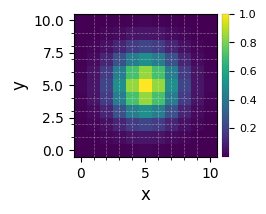

In [38]:
psf = create_synth_psf(model='gauss', shape=(11, 11), fwhm=4.)
plot_frames(psf, grid=True, size_factor=2)

Then we inject the disk in the cube and convolve each frame by the PSF

In [39]:
cube_fake_disk3_convolved = cube_inject_fakedisk(fake_disk3_map, -derotation_angles,
                                                 psf=psf, imlib='vip-fft')

Warning the PSF is not normalized to a total of 1. Normalization was forced.


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 01:22:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:02.711040
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


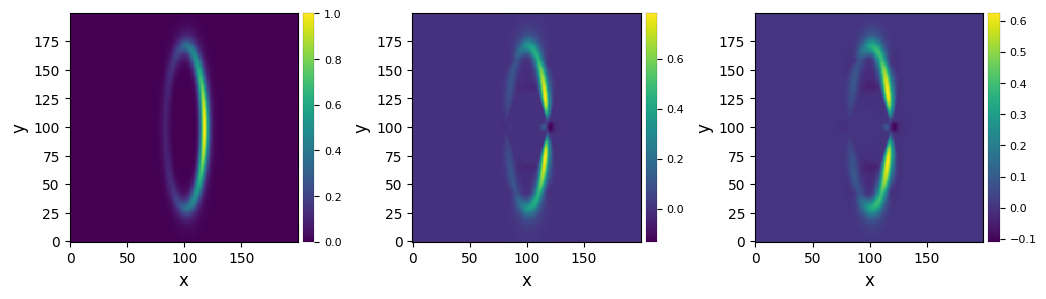

In [40]:
cadi_fake_disk3_convolved = median_sub(cube_fake_disk3_convolved, derotation_angles, imlib='vip-fft')

plot_frames((fake_disk3_map, cadi_fake_disk3, cadi_fake_disk3_convolved), grid=False, size_factor=4)

In practice, the synthetic cube is often used to subtract it to a real data cube in order to subtract the disk signal. The cube can then be reduced again and one iterates over the disk parameters in order to minimize the residuals after the ADI reduction. 

An alternative approach is to compute the forward model of the disk (right image above) and subtract the forward model image from the ADI image. This is easy in classical ADI or in PCA if one stores the principal components.